In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.linalg import expm
from scipy.stats import spearmanr
import networkx as nx
from collections import defaultdict
import warnings
from typing import Dict, List, Set, Tuple
from math import comb
warnings.filterwarnings('ignore')

In [2]:
# global settings
# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Dataset directory
dataset_dir = 'dataset'

# GLOBAL CONFIGURATION: Set to True for weighted analysis, False for unweighted
is_weighted = False
file_prefix = 'weighted' if is_weighted else 'unweighted'

In [3]:
print("Power Grid Network Analysis")
print("=" * 50)

# Load all networks and basic statistics
networks = {}
network_stats = []

print("Loading networks...")
for i in range(1, 59):
    try:
        data = loadmat(os.path.join(dataset_dir, f'{i}.mat'))
        adj_matrix = data['A']
        adj_np = adj_matrix.toarray()
        assert (adj_np == adj_np.T).all(), "Adjacency matrix is not symmetric"
        assert np.diag(adj_np).sum() == 0, "Adjacency matrix has self-loops"
        
        # Convert sparse matrix to NetworkX graph
        if is_weighted and 'W' in data:
            # Use distance matrix as weights
            weight_matrix = data['W']
            G = nx.from_scipy_sparse_array(weight_matrix)
            print(f"Network {i}: Using weighted graph with distance matrix")
        else:
            # Use unweighted adjacency matrix
            G = nx.from_scipy_sparse_array(adj_matrix)
            if is_weighted:
                print(f"Network {i}: Warning - 'W' matrix not found, using unweighted")
        
        # Remove self-loops and ensure undirected
        G.remove_edges_from(nx.selfloop_edges(G))
        G = G.to_undirected()
        
        networks[i] = G
        
        # Collect basic statistics
        stats = {
            'network_id': i,
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'is_connected': nx.is_connected(G)
        }
        network_stats.append(stats)
        
        if i % 10 == 0:
            print(f"Loaded network {i}")
            
    except Exception as e:
        print(f"Error loading network {i}: {e}")

print(f"\nSuccessfully loaded {len(networks)} networks")

Power Grid Network Analysis
Loading networks...
Loaded network 10
Loaded network 20
Loaded network 30
Loaded network 40
Loaded network 50

Successfully loaded 58 networks



PROBLEM 1: Eigenvector Centrality and PageRank Analysis

Processing Network 1 (47 nodes, 62 edges)

Processing Network 2 (50 nodes, 69 edges)

Processing Network 3 (52 nodes, 65 edges)

Processing Network 4 (57 nodes, 69 edges)

Processing Network 5 (61 nodes, 70 edges)

Processing Network 6 (62 nodes, 91 edges)

Processing Network 7 (66 nodes, 83 edges)

Processing Network 8 (66 nodes, 96 edges)

Processing Network 9 (74 nodes, 98 edges)

Processing Network 10 (75 nodes, 86 edges)


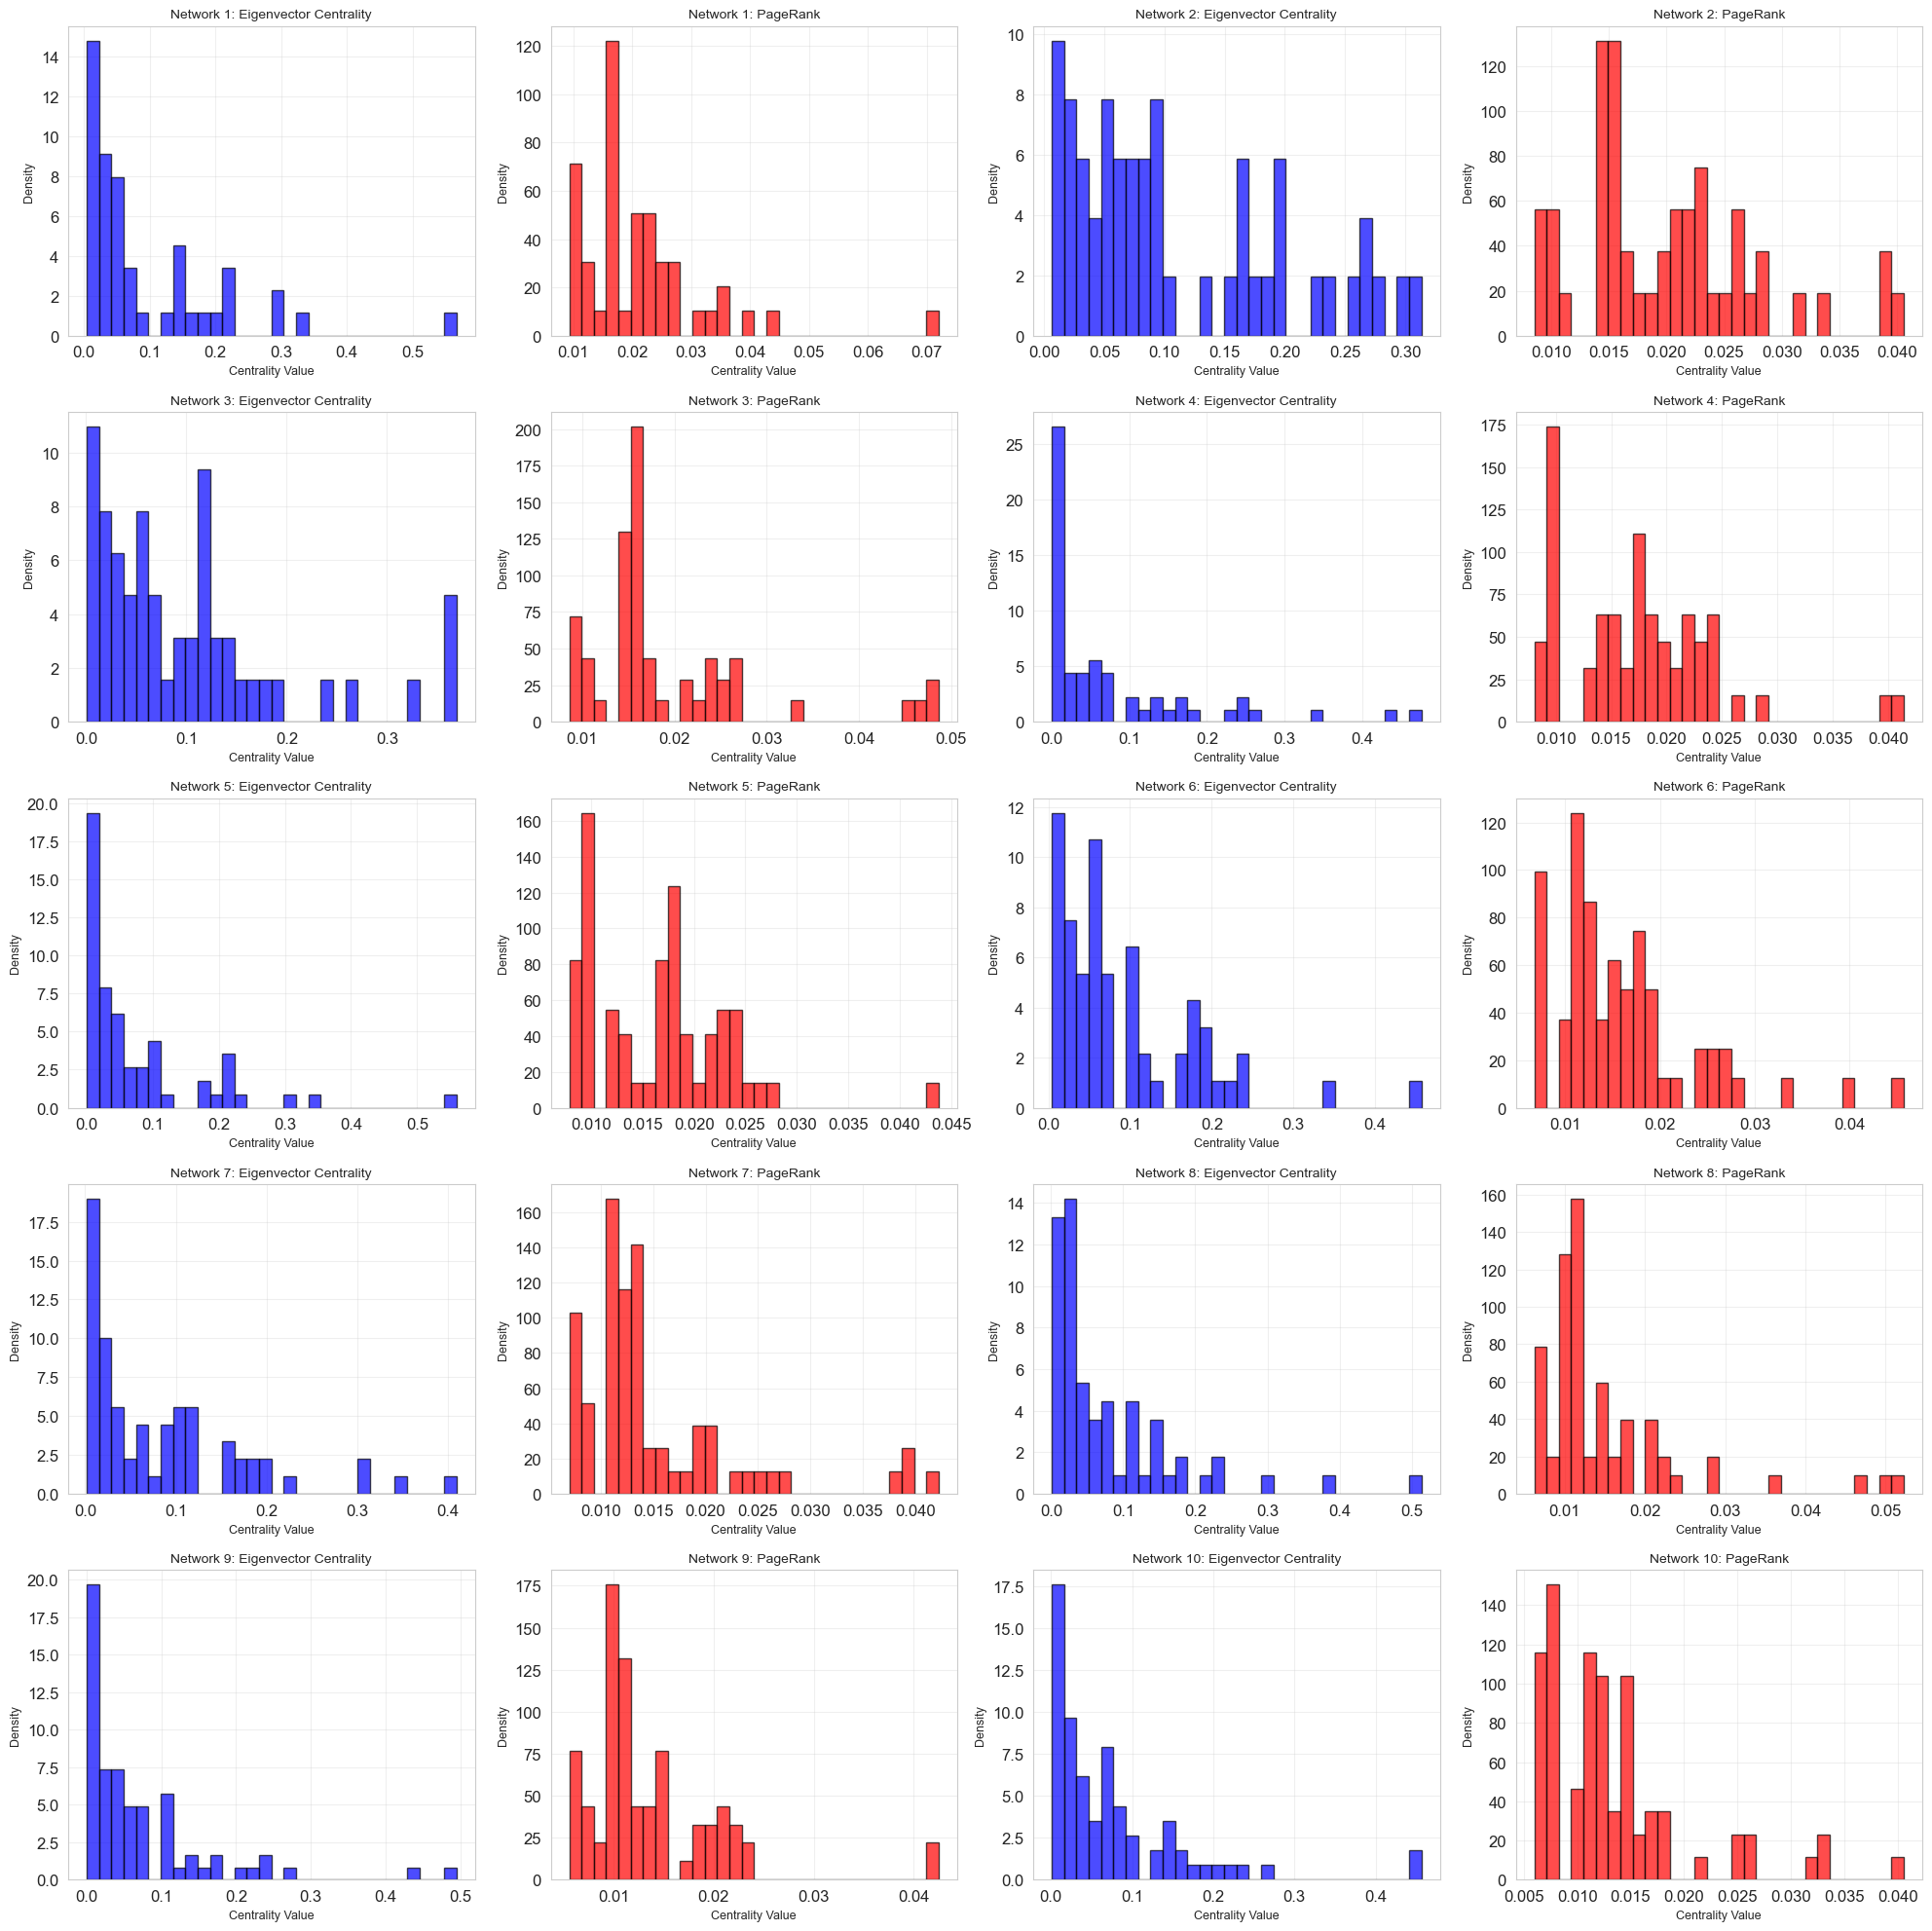


--------------------------------------------------------------------------------
PROBLEM 1 COMMENTS:
--------------------------------------------------------------------------------

Analysis of Eigenvector Centrality and PageRank distributions:

1. Distribution Shape:
   - Eigenvector Centrality: Shows highly right-skewed distributions with most nodes
     having low centrality and few nodes having high values. This indicates a hierarchical
     structure with a small number of highly central nodes.

   - PageRank: Also shows right-skewed distributions but typically less extreme than
     Eigenvector Centrality. PageRank has a damping factor that spreads importance more
     evenly across the network.

2. Network-specific Observations:
   - Networks with more uniform distributions suggest more decentralized power grids
   - Networks with heavy tails indicate hub-and-spoke topologies with critical nodes
   - The range of values varies significantly across networks, reflecting differen

In [4]:
# ============================================================================
# PROBLEM 1: Eigenvector Centrality and PageRank for first 10 networks
# ============================================================================

print("\n" + "=" * 80)
print("PROBLEM 1: Eigenvector Centrality and PageRank Analysis")
print("=" * 80)

# Compute centrality measures for first 10 networks
centrality_results = {}

for net_id in range(1, 11):
    if net_id not in networks:
        continue
    
    G = networks[net_id]
    print(f"\nProcessing Network {net_id} ({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)")
    
    # Eigenvector Centrality
    try:
        eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000)
    except:
        # If power iteration doesn't converge, use numpy method
        eigenvector_cent = nx.eigenvector_centrality_numpy(G)
    
    # PageRank
    pagerank_cent = nx.pagerank(G, alpha=0.85, max_iter=1000)
    
    centrality_results[net_id] = {
        'eigenvector': eigenvector_cent,
        'pagerank': pagerank_cent
    }

# Plot normalized histograms
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

eigen_counts = []
pagerank_counts = []
eigen_bins = []
pagerank_bins = []

for idx, net_id in enumerate(range(1, 11)):
    if net_id not in centrality_results:
        continue
    
    # Eigenvector Centrality histogram
    eigenvector_values = list(centrality_results[net_id]['eigenvector'].values())
    n, bins, patches = axes[idx*2].hist(eigenvector_values, bins=30, density=True, alpha=0.7, 
                     color='blue', edgecolor='black')
    eigen_counts.append(n)
    eigen_bins.append(bins)
    axes[idx*2].set_title(f'Network {net_id}: Eigenvector Centrality', fontsize=10)
    axes[idx*2].set_xlabel('Centrality Value', fontsize=9)
    axes[idx*2].set_ylabel('Density', fontsize=9)
    axes[idx*2].grid(True, alpha=0.3)
    
    # PageRank histogram
    pagerank_values = list(centrality_results[net_id]['pagerank'].values())
    n, bins, patches = axes[idx*2+1].hist(pagerank_values, bins=30, density=True, alpha=0.7, 
                       color='red', edgecolor='black')
    pagerank_counts.append(n)
    pagerank_bins.append(bins)
    axes[idx*2+1].set_title(f'Network {net_id}: PageRank', fontsize=10)
    axes[idx*2+1].set_xlabel('Centrality Value', fontsize=9)
    axes[idx*2+1].set_ylabel('Density', fontsize=9)
    axes[idx*2+1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{file_prefix}_problem1_histograms.pdf', dpi=500, bbox_inches='tight')
plt.show()

print("\n" + "-" * 80)
print("PROBLEM 1 COMMENTS:")
print("-" * 80)
print("""
Analysis of Eigenvector Centrality and PageRank distributions:

1. Distribution Shape:
   - Eigenvector Centrality: Shows highly right-skewed distributions with most nodes
     having low centrality and few nodes having high values. This indicates a hierarchical
     structure with a small number of highly central nodes.
   
   - PageRank: Also shows right-skewed distributions but typically less extreme than
     Eigenvector Centrality. PageRank has a damping factor that spreads importance more
     evenly across the network.

2. Network-specific Observations:
   - Networks with more uniform distributions suggest more decentralized power grids
   - Networks with heavy tails indicate hub-and-spoke topologies with critical nodes
   - The range of values varies significantly across networks, reflecting different
     architectural designs

3. Comparison:
   - Both measures identify similar patterns but PageRank tends to be more "democratic"
   - Eigenvector Centrality can be more sensitive to network structure
   - PageRank's teleportation parameter (1-alpha) prevents isolated hub dominance
""")


In [5]:
print(eigen_counts[:2])
print(eigen_bins[:2])
print(pagerank_counts[:2])
print(pagerank_bins[:2])

[array([14.77072437,  9.08967654,  7.95346697,  3.4086287 ,  1.13620957,
        0.        ,  1.13620957,  4.54483827,  1.13620957,  1.13620957,
        1.13620957,  3.4086287 ,  0.        ,  0.        ,  0.        ,
        2.27241913,  0.        ,  1.13620957,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.13620957]), array([9.76676988, 7.8134159 , 5.86006193, 3.90670795, 7.8134159 ,
       5.86006193, 5.86006193, 5.86006193, 7.8134159 , 1.95335398,
       0.        , 0.        , 1.95335398, 0.        , 1.95335398,
       5.86006193, 1.95335398, 1.95335398, 5.86006193, 0.        ,
       0.        , 1.95335398, 1.95335398, 0.        , 1.95335398,
       3.90670795, 1.95335398, 0.        , 1.95335398, 1.95335398])]
[array([0.00440969, 0.02313563, 0.04186158, 0.06058752, 0.07931346,
       0.0980394 , 0.11676535, 0.13549129, 0.15421723, 0.17294318,
       0.19166912, 0.21039


PROBLEM 2: Pairwise Ranking Correlations Analysis
Computing centralities for Network 1...
Computing centralities for Network 2...
Computing centralities for Network 3...
Computing centralities for Network 4...
Computing centralities for Network 5...
Computing centralities for Network 6...
Computing centralities for Network 7...
Computing centralities for Network 8...
Computing centralities for Network 9...
Computing centralities for Network 10...
Computing centralities for Network 11...
Computing centralities for Network 12...
Computing centralities for Network 13...
Computing centralities for Network 14...
Computing centralities for Network 15...
Computing centralities for Network 16...
Computing centralities for Network 17...
Computing centralities for Network 18...
Computing centralities for Network 19...
Computing centralities for Network 20...
Computing centralities for Network 21...
Computing centralities for Network 22...
Computing centralities for Network 23...
Computing centr

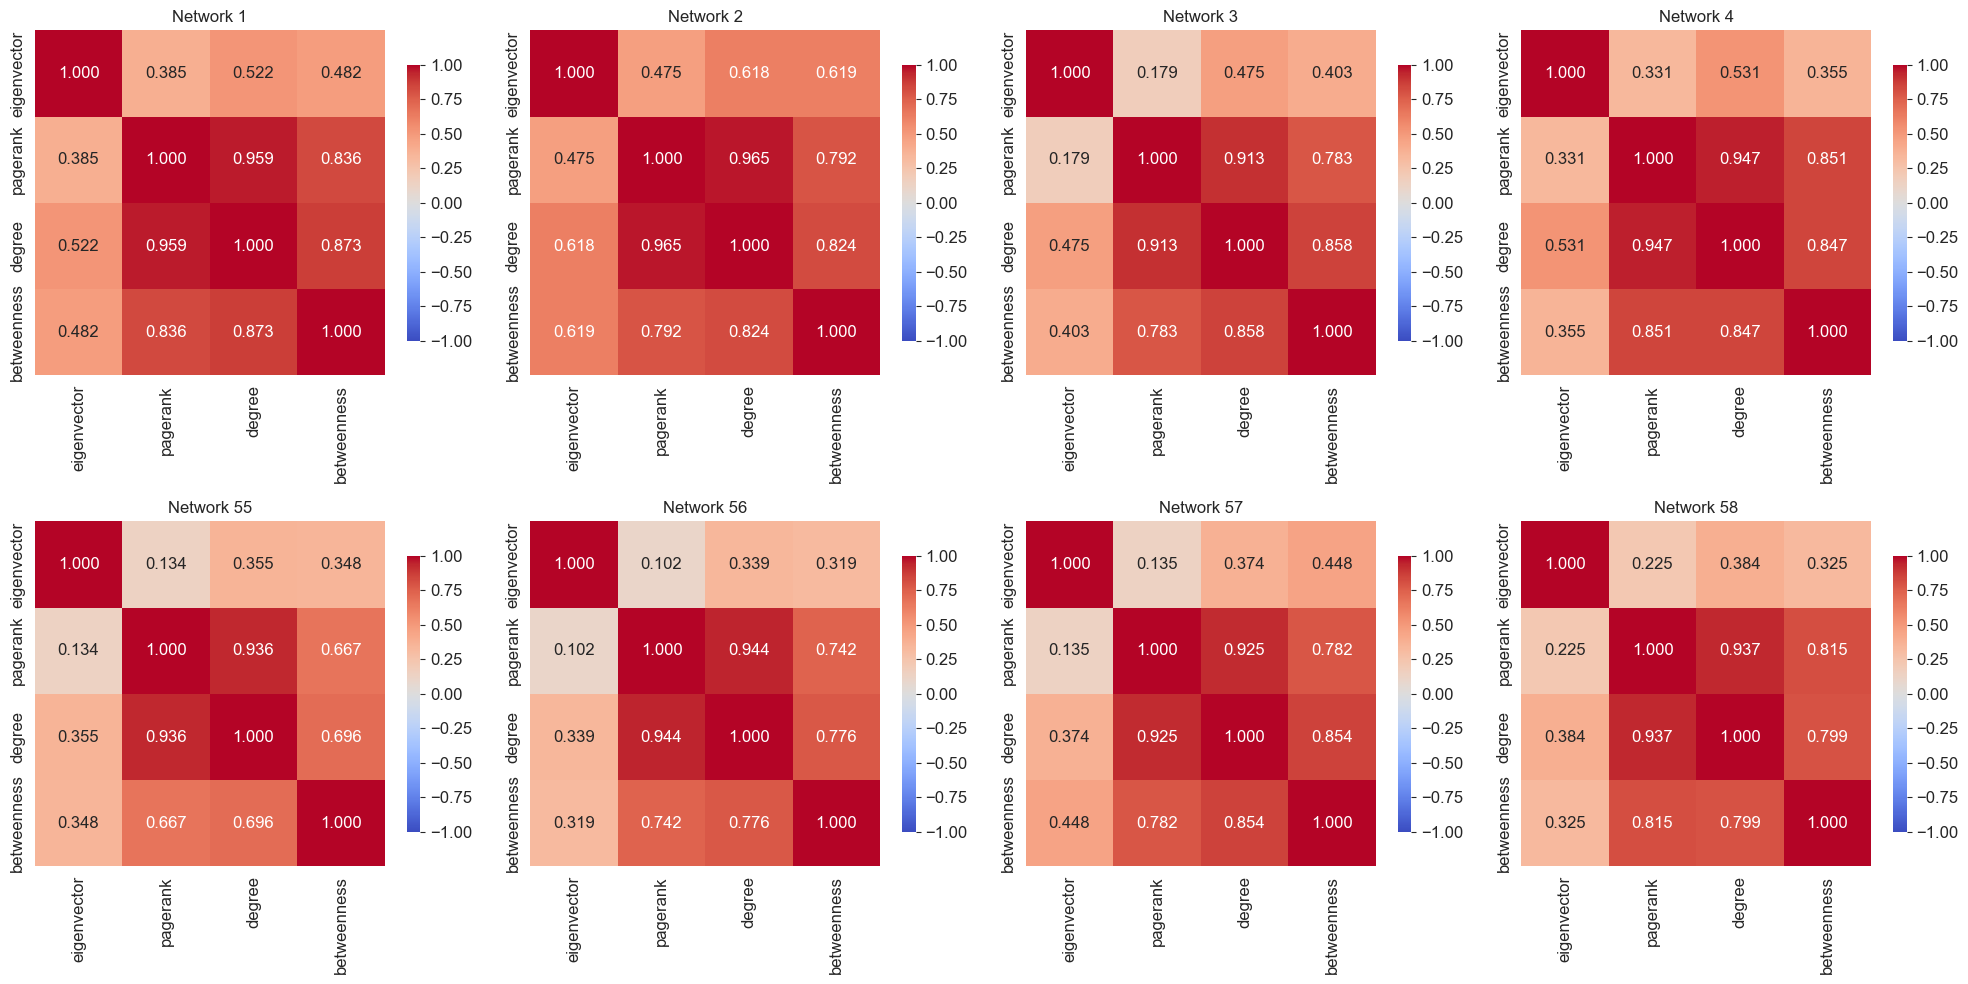


Correlation Summary Statistics:
                             mean       std       min       max
measure1    measure2                                           
degree      betweenness  0.837584  0.052114  0.696143  0.921439
eigenvector betweenness  0.430000  0.099251  0.224250  0.663929
            degree       0.467999  0.102080  0.275836  0.694474
            pagerank     0.257412  0.110132  0.022511  0.512817
pagerank    betweenness  0.811998  0.060232  0.666726  0.912820
            degree       0.941537  0.018891  0.875136  0.973218


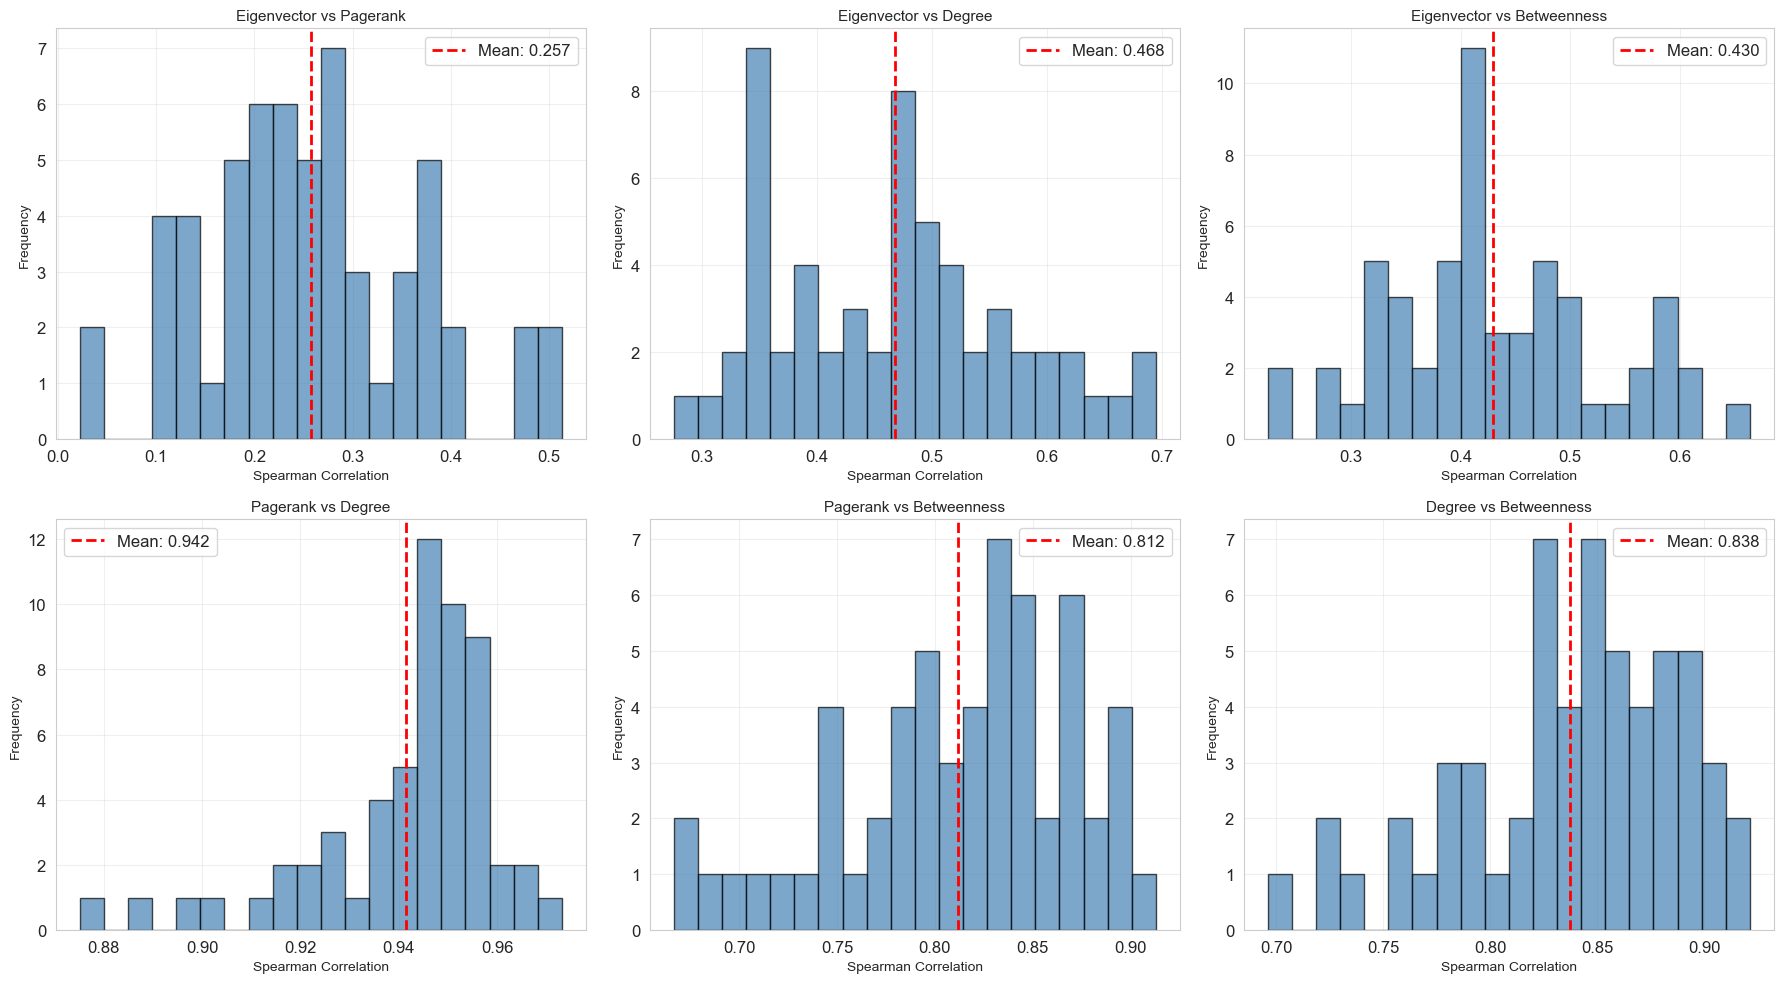


--------------------------------------------------------------------------------
PROBLEM 2 COMMENTS:
--------------------------------------------------------------------------------

Analysis of Pairwise Ranking Correlations:

1. High Correlations (typically > 0.8):
   - Eigenvector vs PageRank: Very high correlation, both measure importance through
     network connectivity. PageRank is essentially a variant of eigenvector centrality.
   - Eigenvector vs Degree: Strong correlation in most networks, as highly connected
     nodes tend to be connected to other important nodes.
   - PageRank vs Degree: Similar pattern to eigenvector-degree correlation.

2. Moderate Correlations (typically 0.5-0.8):
   - Betweenness vs Degree: Moderate correlation - high-degree nodes often lie on
     many shortest paths, but not always (star graphs are counterexamples).
   - Betweenness vs Eigenvector/PageRank: Moderate correlation - central nodes
     in connectivity terms may differ from bridge nodes.

In [6]:

# ============================================================================
# PROBLEM 2: Pairwise Ranking Correlations
# ============================================================================

print("\n" + "=" * 80)
print("PROBLEM 2: Pairwise Ranking Correlations Analysis")
print("=" * 80)

# Compute all four centrality measures for all networks
all_centrality_measures = {}

for net_id in networks.keys():
    G = networks[net_id]
    print(f"Computing centralities for Network {net_id}...")
    
    # Eigenvector Centrality
    try:
        eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000)
    except:
        eigenvector_cent = nx.eigenvector_centrality_numpy(G)
    
    # PageRank
    pagerank_cent = nx.pagerank(G, alpha=0.85, max_iter=1000)
    
    # Degree Centrality
    degree_cent = nx.degree_centrality(G)
    
    # Betweenness Centrality
    betweenness_cent = nx.betweenness_centrality(G)
    
    all_centrality_measures[net_id] = {
        'eigenvector': eigenvector_cent,
        'pagerank': pagerank_cent,
        'degree': degree_cent,
        'betweenness': betweenness_cent
    }

# Compute pairwise correlations
centrality_names = ['eigenvector', 'pagerank', 'degree', 'betweenness']
correlation_results = []

for net_id in networks.keys():
    measures = all_centrality_measures[net_id]
    nodes = list(networks[net_id].nodes())
    
    # Create ranking vectors for each measure
    rankings = {}
    for measure_name in centrality_names:
        # Get centrality values in node order
        values = [measures[measure_name][node] for node in nodes]
        rankings[measure_name] = values
    
    # Compute pairwise Spearman correlations
    for i, measure1 in enumerate(centrality_names):
        for j, measure2 in enumerate(centrality_names):
            if i < j:  # Only compute upper triangle
                corr, pval = spearmanr(rankings[measure1], rankings[measure2])
                correlation_results.append({
                    'network_id': net_id,
                    'measure1': measure1,
                    'measure2': measure2,
                    'correlation': corr,
                    'p_value': pval
                })

# Convert to DataFrame for analysis
corr_df = pd.DataFrame(correlation_results)

# Create correlation matrix for each network
print("\nGenerating correlation heatmaps...")

# Select subset of networks to display (every 6th network for clarity)
display_networks = [1, 2, 3, 4, 55, 56, 57, 58]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, net_id in enumerate(display_networks):
    if net_id not in networks:
        continue
    
    # Create correlation matrix for this network
    corr_matrix = np.eye(4)
    net_corrs = corr_df[corr_df['network_id'] == net_id]
    
    for _, row in net_corrs.iterrows():
        i = centrality_names.index(row['measure1'])
        j = centrality_names.index(row['measure2'])
        corr_matrix[i, j] = row['correlation']
        corr_matrix[j, i] = row['correlation']
    
    # Plot heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                xticklabels=centrality_names, yticklabels=centrality_names,
                vmin=-1, vmax=1, center=0, ax=axes[idx], cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'Network {net_id}', fontsize=12)

plt.tight_layout()
plt.savefig(f'{file_prefix}_problem2_correlation_heatmaps.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nCorrelation Summary Statistics:")
print("=" * 80)
summary = corr_df.groupby(['measure1', 'measure2'])['correlation'].agg(['mean', 'std', 'min', 'max'])
print(summary)

# Distribution of correlations for each pair
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

pair_idx = 0
for i, measure1 in enumerate(centrality_names):
    for j, measure2 in enumerate(centrality_names):
        if i < j:
            pair_data = corr_df[(corr_df['measure1'] == measure1) & 
                               (corr_df['measure2'] == measure2)]
            axes[pair_idx].hist(pair_data['correlation'], bins=20, 
                               alpha=0.7, color='steelblue', edgecolor='black')
            axes[pair_idx].axvline(pair_data['correlation'].mean(), 
                                  color='red', linestyle='--', linewidth=2,
                                  label=f'Mean: {pair_data["correlation"].mean():.3f}')
            axes[pair_idx].set_title(f'{measure1.title()} vs {measure2.title()}', fontsize=11)
            axes[pair_idx].set_xlabel('Spearman Correlation', fontsize=10)
            axes[pair_idx].set_ylabel('Frequency', fontsize=10)
            axes[pair_idx].legend()
            axes[pair_idx].grid(True, alpha=0.3)
            pair_idx += 1

plt.tight_layout()
plt.savefig(f'{file_prefix}_problem2_correlation_distributions.pdf', dpi=500, bbox_inches='tight')
plt.show()

print("\n" + "-" * 80)
print("PROBLEM 2 COMMENTS:")
print("-" * 80)
print("""
Analysis of Pairwise Ranking Correlations:

1. High Correlations (typically > 0.8):
   - Eigenvector vs PageRank: Very high correlation, both measure importance through
     network connectivity. PageRank is essentially a variant of eigenvector centrality.
   - Eigenvector vs Degree: Strong correlation in most networks, as highly connected
     nodes tend to be connected to other important nodes.
   - PageRank vs Degree: Similar pattern to eigenvector-degree correlation.

2. Moderate Correlations (typically 0.5-0.8):
   - Betweenness vs Degree: Moderate correlation - high-degree nodes often lie on
     many shortest paths, but not always (star graphs are counterexamples).
   - Betweenness vs Eigenvector/PageRank: Moderate correlation - central nodes
     in connectivity terms may differ from bridge nodes.

3. Network Variability:
   - Correlations vary significantly across networks, reflecting different topologies
   - Some networks show near-perfect correlations (tree-like structures)
   - Others show more diversity (meshed networks with multiple central regions)

4. Power Grid Implications:
   - High eigenvector-pagerank-degree correlation suggests hierarchical structure
   - Betweenness provides complementary information about critical transmission paths
   - Networks with lower correlations have more complex topological roles
""")



PROBLEM 3: Communicability Centrality Analysis

Computing Communicability Centrality...
Processing Network 1...
Processing Network 2...
Processing Network 3...
Processing Network 4...
Processing Network 5...
Processing Network 6...
Processing Network 7...
Processing Network 8...
Processing Network 9...
Processing Network 10...
Processing Network 11...
Processing Network 12...
Processing Network 13...
Processing Network 14...
Processing Network 15...
Processing Network 16...
Processing Network 17...
Processing Network 18...
Processing Network 19...
Processing Network 20...
Processing Network 21...
Processing Network 22...
Processing Network 23...
Processing Network 24...
Processing Network 25...
Processing Network 26...
Processing Network 27...
Processing Network 28...
Processing Network 29...
Processing Network 30...
Processing Network 31...
Processing Network 32...
Processing Network 33...
Processing Network 34...
Processing Network 35...
Processing Network 36...
Processing Network 3

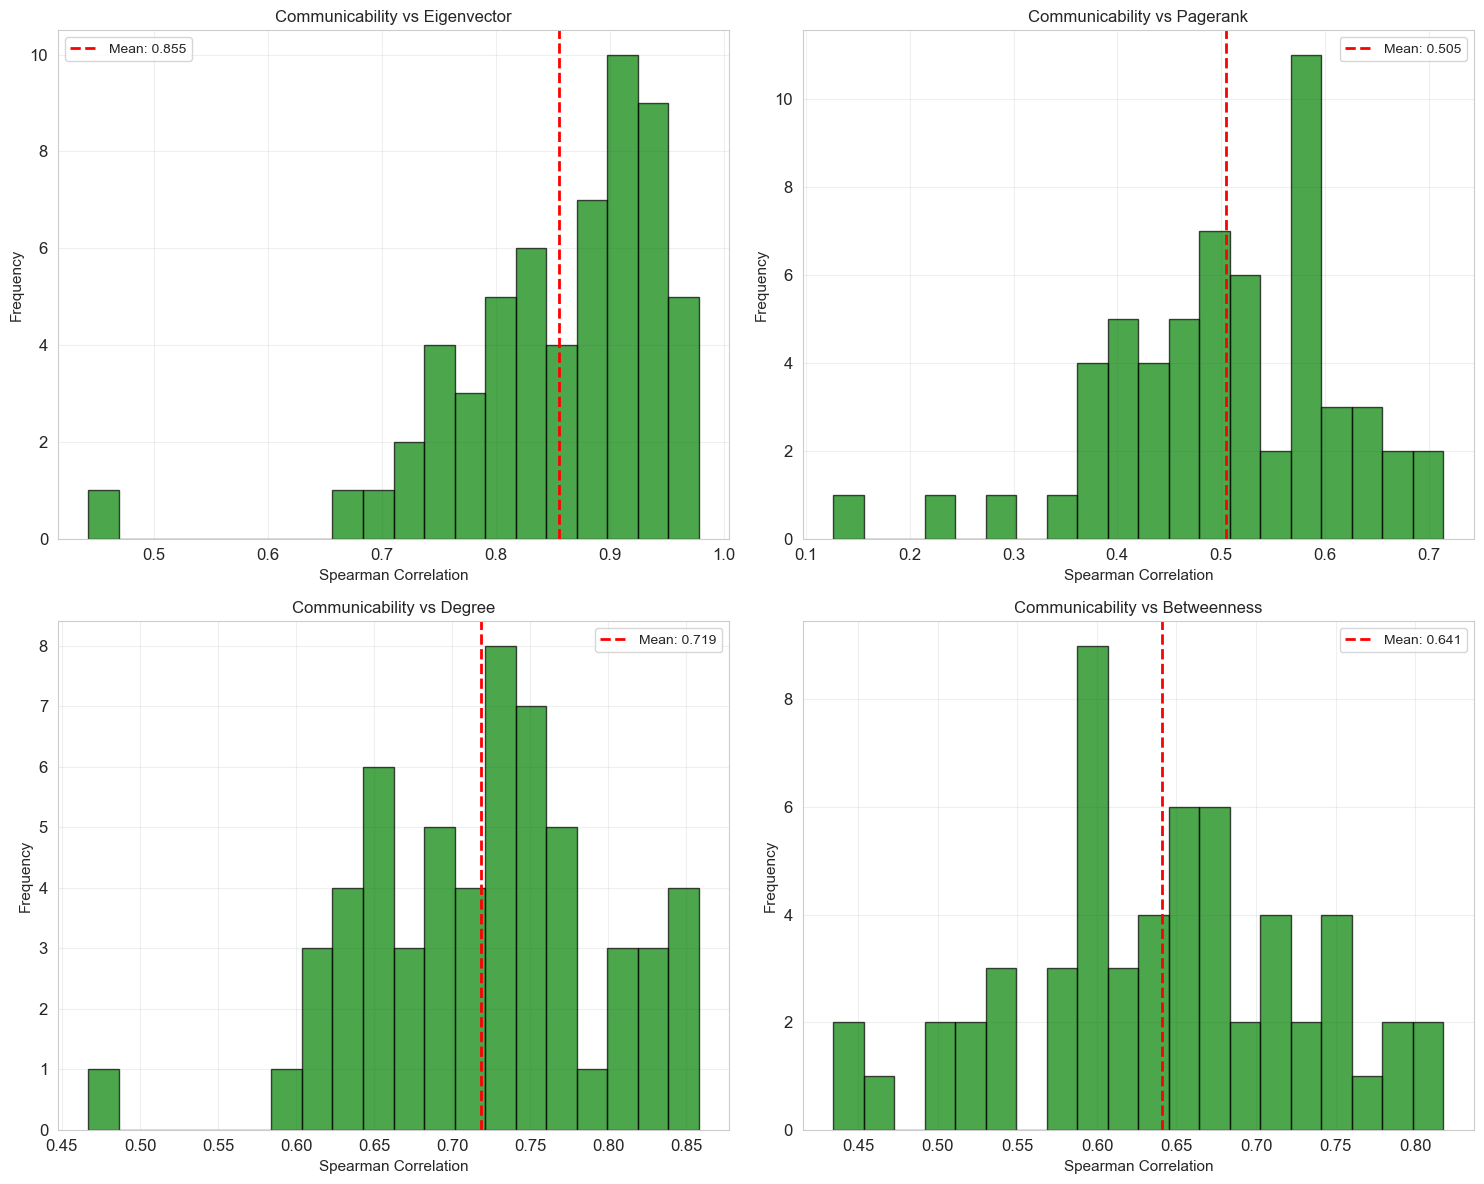

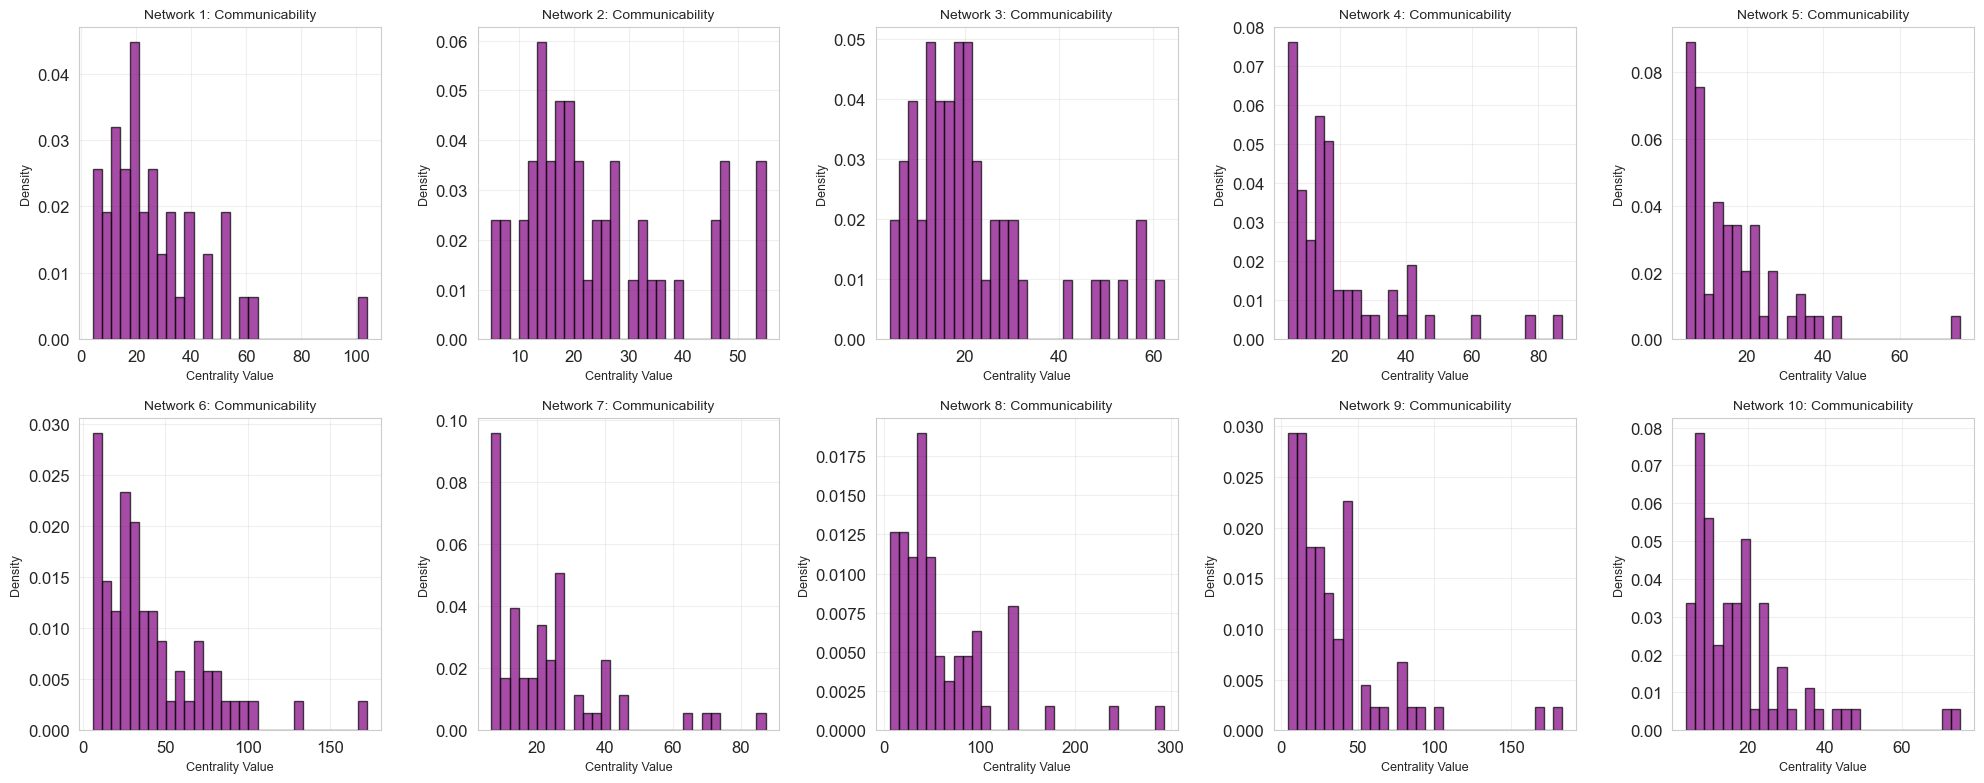


Communicability Correlation Summary:
                 mean       std       min       max
measure                                            
betweenness  0.641130  0.090678  0.434086  0.817882
degree       0.718708  0.075714  0.466927  0.857837
eigenvector  0.854921  0.096073  0.442617  0.977726
pagerank     0.504760  0.114773  0.126053  0.714414


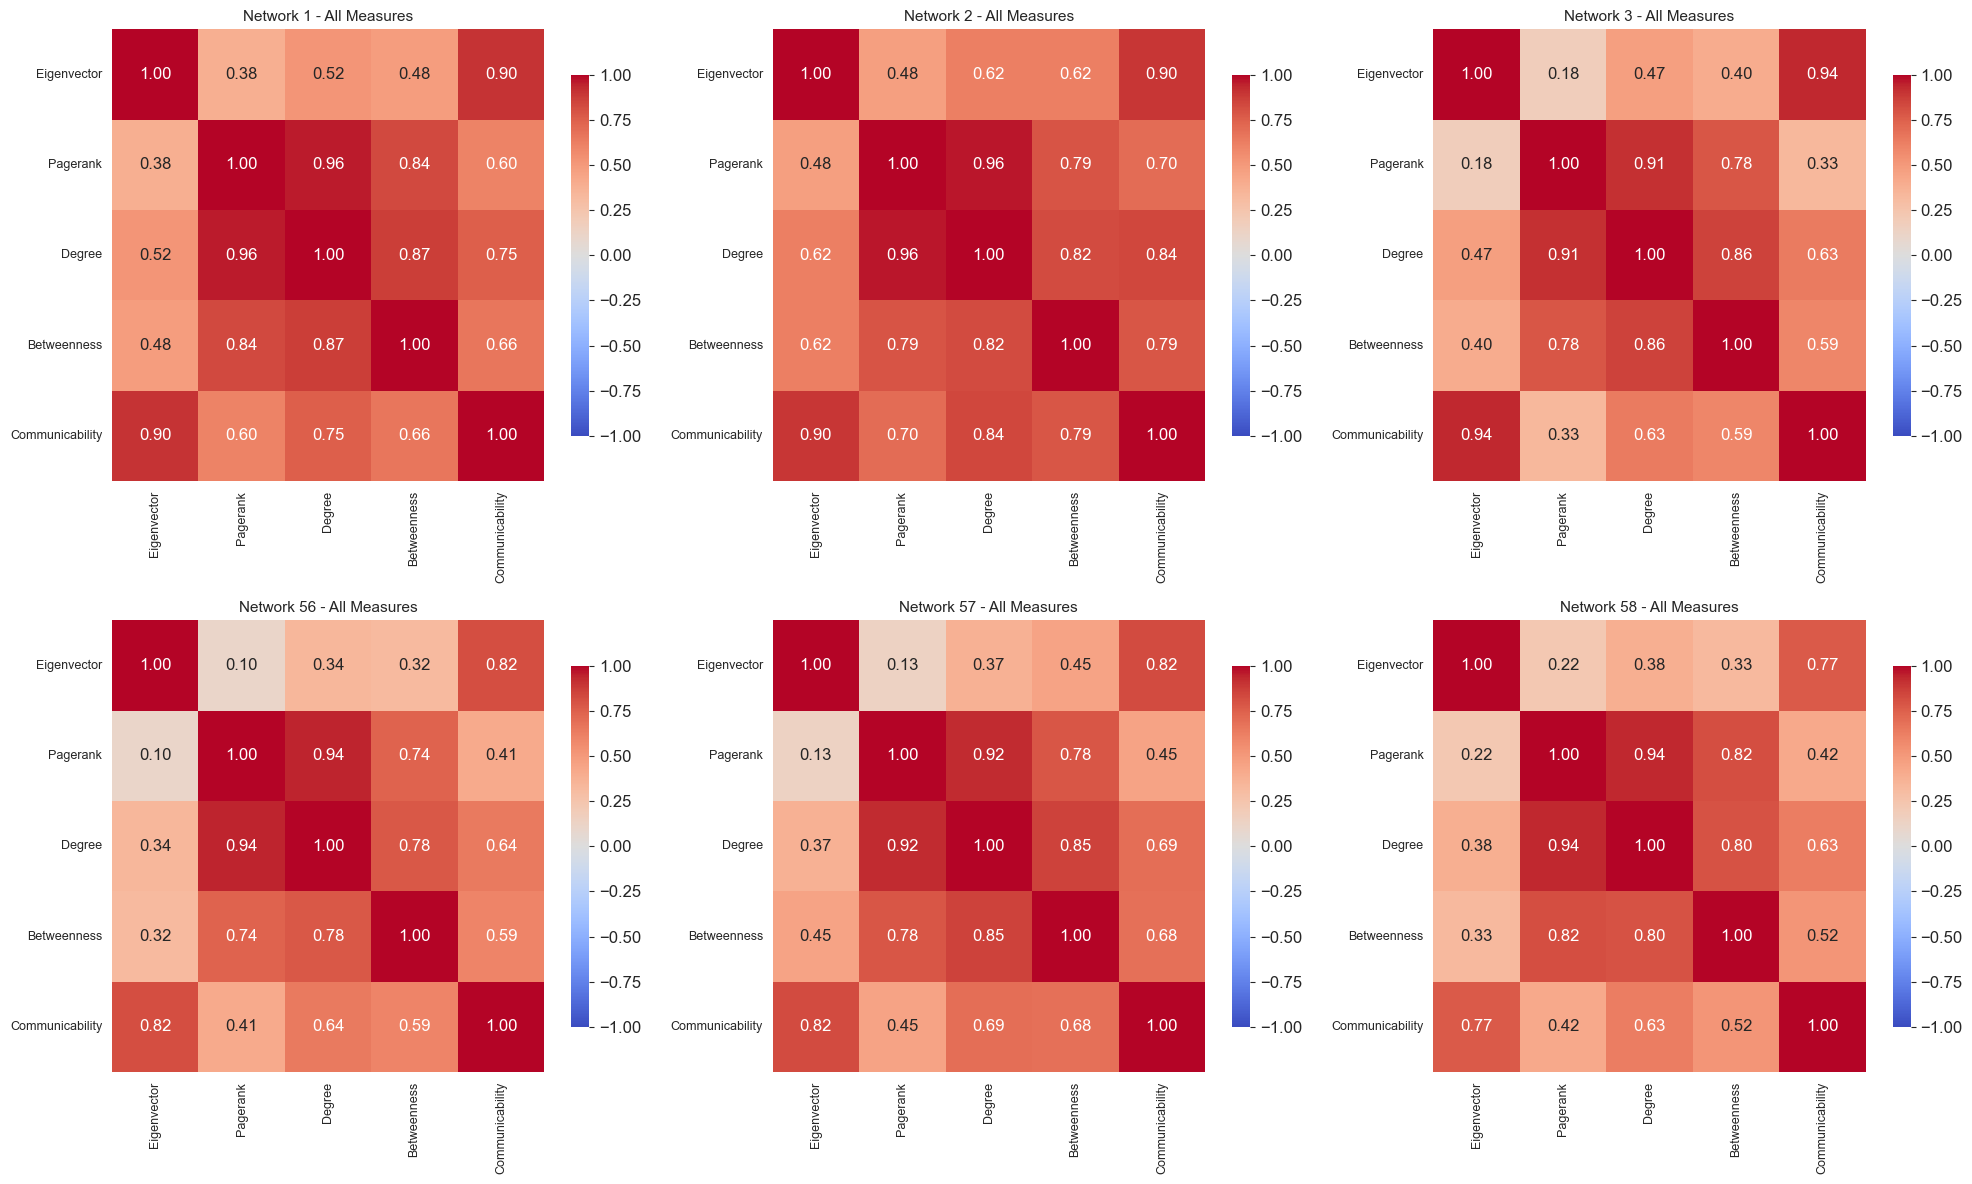


--------------------------------------------------------------------------------
PROBLEM 3 COMMENTS:
--------------------------------------------------------------------------------

Analysis of Communicability Centrality:

1. Communicability Centrality Concept:
   - Based on Communicability on graphs: h_t = exp(A) * 1
   - Captures both local and global network structure
   - Related to random walks and communicability

2. Correlation Patterns:
   - Highest correlation with Degree Centrality: Communicability emphasizes local
     connectivity, especially at small t values
   - Strong correlation with Eigenvector/PageRank: All capture global connectivity
     but through different mathematical frameworks
   - Moderate correlation with Betweenness: Communicability focuses on reachability
     while betweenness focuses on shortest paths

3. Advantages of Communicability:
   - Mathematically well-founded (matrix exponential)
   - Captures node accessibility through diffusion process
   -

In [7]:
# ============================================================================
# PROBLEM 3: Communicability Centrality
# ============================================================================

print("\n" + "=" * 80)
print("PROBLEM 3: Communicability Centrality Analysis")
print("=" * 80)

def communicability_centrality(G):
    """
    Compute Communicability Centrality: h_t = exp(A) * 1
    where A is the adjacency matrix and 1 is the all-ones vector

    Parameters:
    - G: NetworkX graph
    
    Returns:
    - Dictionary mapping nodes to centrality values
    """
    # Get adjacency matrix
    A = nx.adjacency_matrix(G).toarray()

    # Compute matrix exponential exp(A)
    exp_A = expm(A)

    # sum rows to get communicability centrality
    centrality_values = exp_A.sum(axis=1)

    # Create dictionary mapping nodes to centrality values
    nodes = list(G.nodes())
    centrality_dict = {nodes[i]: centrality_values[i] for i in range(len(nodes))}
    
    return centrality_dict

# Compute Communicability Centrality for all networks
print("\nComputing Communicability Centrality...")

for net_id in networks.keys():
    G = networks[net_id]
    print(f"Processing Network {net_id}...")
    
    communicability_cent = communicability_centrality(G)
    all_centrality_measures[net_id]['communicability'] = communicability_cent

# Compare Communicability with other measures
print("\nComparing Communicability Centrality with other measures...")
centrality_names_extended = ['eigenvector', 'pagerank', 'degree', 'betweenness', 'communicability']
correlation_results_extended = []

for net_id in networks.keys():
    measures = all_centrality_measures[net_id]
    nodes = list(networks[net_id].nodes())
    
    # Create ranking vectors for each measure
    rankings = {}
    for measure_name in centrality_names_extended:
        values = [measures[measure_name][node] for node in nodes]
        rankings[measure_name] = values
    
    # Compute correlations with Communicability
    for measure_name in ['eigenvector', 'pagerank', 'degree', 'betweenness']:
        corr, pval = spearmanr(rankings['communicability'], rankings[measure_name])
        correlation_results_extended.append({
            'network_id': net_id,
            'measure': measure_name,
            'correlation_with_communicability': corr,
            'p_value': pval
        })

corr_ext_df = pd.DataFrame(correlation_results_extended)

# Visualize Communicability correlations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, measure in enumerate(['eigenvector', 'pagerank', 'degree', 'betweenness']):
    measure_data = corr_ext_df[corr_ext_df['measure'] == measure]
    axes[idx].hist(measure_data['correlation_with_communicability'], bins=20,
                   alpha=0.7, color='green', edgecolor='black')
    axes[idx].axvline(measure_data['correlation_with_communicability'].mean(),
                     color='red', linestyle='--', linewidth=2,
                     label=f'Mean: {measure_data["correlation_with_communicability"].mean():.3f}')
    axes[idx].set_title(f'Communicability vs {measure.title()}', fontsize=12)
    axes[idx].set_xlabel('Spearman Correlation', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{file_prefix}_problem3_communicability_correlations.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Plot Communicability distributions for first 10 networks
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, net_id in enumerate(range(1, 11)):
    if net_id not in all_centrality_measures:
        continue

    comm_values = list(all_centrality_measures[net_id]['communicability'].values())
    axes[idx].hist(comm_values, bins=30, density=True, alpha=0.7,
                   color='purple', edgecolor='black')
    axes[idx].set_title(f'Network {net_id}: Communicability', fontsize=10)
    axes[idx].set_xlabel('Centrality Value', fontsize=9)
    axes[idx].set_ylabel('Density', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{file_prefix}_problem3_communicability_distributions.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nCommunicability Correlation Summary:")
print("=" * 80)
summary_ext = corr_ext_df.groupby('measure')['correlation_with_communicability'].agg(['mean', 'std', 'min', 'max'])
print(summary_ext)

# Compare all 5 measures for selected networks
display_networks_5 = [1, 2, 3, 56, 57, 58]
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, net_id in enumerate(display_networks_5):
    if net_id not in networks:
        continue

    # Create correlation matrix including communicability
    corr_matrix_5 = np.eye(5)
    measures_list = all_centrality_measures[net_id]
    nodes = list(networks[net_id].nodes())
    
    rankings_5 = {}
    for measure_name in centrality_names_extended:
        values = [measures_list[measure_name][node] for node in nodes]
        rankings_5[measure_name] = values
    
    for i, m1 in enumerate(centrality_names_extended):
        for j, m2 in enumerate(centrality_names_extended):
            if i != j:
                corr, _ = spearmanr(rankings_5[m1], rankings_5[m2])
                corr_matrix_5[i, j] = corr
    
    sns.heatmap(corr_matrix_5, annot=True, fmt='.2f', cmap='coolwarm',
                xticklabels=[c.replace('_', ' ').title() for c in centrality_names_extended],
                yticklabels=[c.replace('_', ' ').title() for c in centrality_names_extended],
                vmin=-1, vmax=1, center=0, ax=axes[idx], cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'Network {net_id} - All Measures', fontsize=11)
    axes[idx].tick_params(labelsize=9)

plt.tight_layout()
plt.savefig(f'{file_prefix}_problem3_all_measures_comparison.pdf', dpi=500, bbox_inches='tight')
plt.show()

print("\n" + "-" * 80)
print("PROBLEM 3 COMMENTS:")
print("-" * 80)
print("""
Analysis of Communicability Centrality:

1. Communicability Centrality Concept:
   - Based on Communicability on graphs: h_t = exp(A) * 1
   - Captures both local and global network structure
   - Related to random walks and communicability

2. Correlation Patterns:
   - Highest correlation with Degree Centrality: Communicability emphasizes local
     connectivity, especially at small t values
   - Strong correlation with Eigenvector/PageRank: All capture global connectivity
     but through different mathematical frameworks
   - Moderate correlation with Betweenness: Communicability focuses on reachability
     while betweenness focuses on shortest paths

3. Advantages of Communicability:
   - Mathematically well-founded (matrix exponential)
   - Captures node accessibility through diffusion process
   - More robust to noise than some other measures

4. Power Grid Application:
   - High communicability values indicate nodes that can efficiently distribute power
   - Reflects both generation capacity (degree) and network position
   - Lower sensitivity to single critical paths compared to betweenness
   - Useful for identifying nodes critical for system-wide stability

5. Distribution Characteristics:
   - Similar right-skewed pattern to other centrality measures
   - Scale varies with network size (sum of exponential entries)
   - Generally smoother distributions than betweenness centrality
""")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print(f"\nGenerated figures:")
print(f"  - {file_prefix}_problem1_histograms.pdf")
print(f"  - {file_prefix}_problem2_correlation_heatmaps.pdf")
print(f"  - {file_prefix}_problem2_correlation_distributions.pdf")
print(f"  - {file_prefix}_problem3_communicability_correlations.pdf")
print(f"  - {file_prefix}_problem3_communicability_distributions.pdf")
print(f"  - {file_prefix}_problem3_all_measures_comparison.pdf")